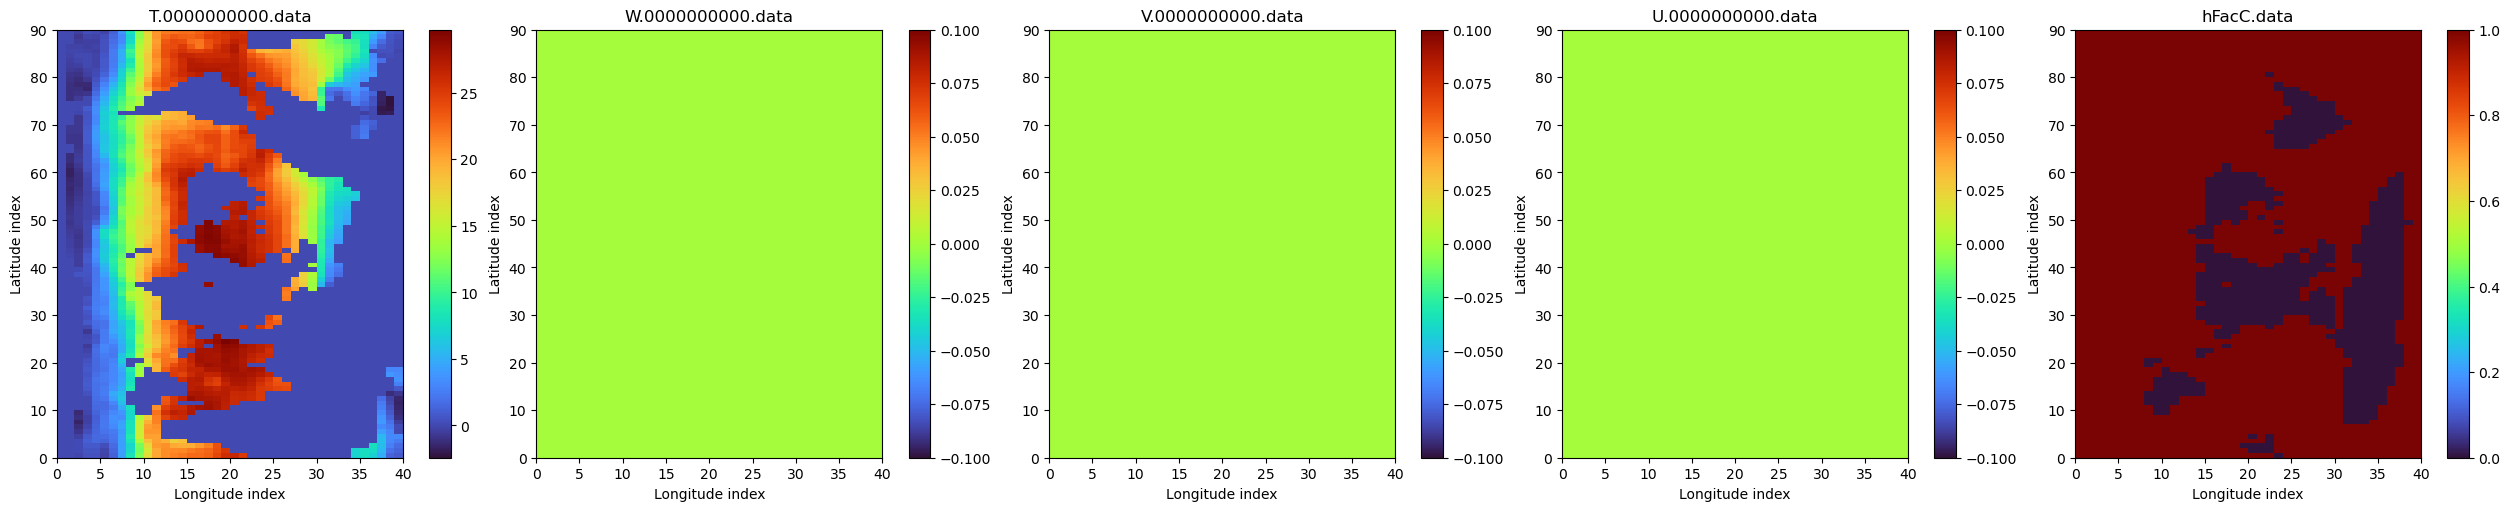

In [31]:
import os
import numpy as np
import matplotlib.pyplot as plt

base_dir   = r"C:/Users/romed/Desktop/github fixer/cs185c_spring2025/modeldubugging"
file_specs = ["T.0000000000.data", "W.0000000000.data", "V.0000000000.data", "U.0000000000.data", "hFacC.data"]

dims = (90, 40, 15)

def load_field(varname):
    path = os.path.join(base_dir, f"{varname}")
    flat = np.fromfile(path, dtype=">f4")                      
    arr3 = flat.reshape(dims, order="F").transpose(2, 0, 1)     
    return arr3

data = {name: load_field(name) for name in file_specs}
n = len(data)
fig, axes = plt.subplots(1, n, figsize=(5*n, 5), constrained_layout=True)

for ax, (name, arr) in zip(axes, data.items()):
    pcm = ax.pcolormesh(arr[0, :, :], shading="auto", cmap="turbo")
    ax.set_title(name)
    ax.set_xlabel("Longitude index")
    ax.set_ylabel("Latitude index")
    fig.colorbar(pcm, ax=ax, orientation="vertical")

plt.show()


2


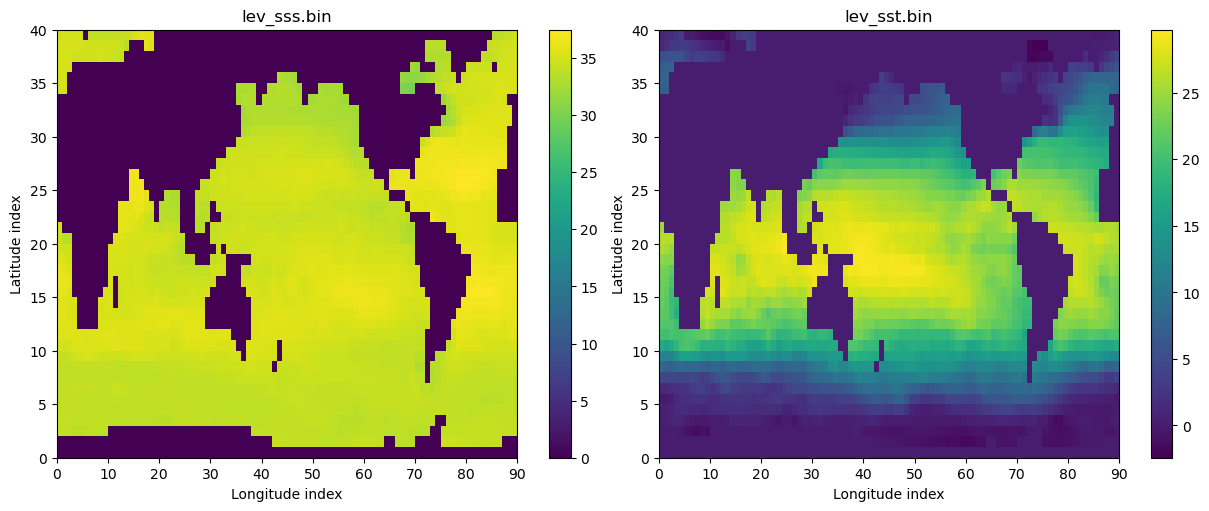

In [16]:
base_dir   = r"C:/Users/romed/Desktop/github fixer/cs185c_spring2025/modeldubugging"
files      = ["lev_sss.bin", "lev_sst.bin"]
orig_dims  = (90, 40, 12)   

data = {}
for fname in files:
    path = os.path.join(base_dir, fname)
    flat = np.fromfile(path, dtype=">f4")
    arr  = flat.reshape(orig_dims, order="F").transpose(2, 1, 0)
    data[fname] = arr


fig, axes = plt.subplots(1, len(files), figsize=(6 * len(files), 5), constrained_layout=True)
print(len(files))
for ax, fname in zip(axes, files):
    arr = data[fname]
    pcm = ax.pcolormesh(arr[0, :, :], shading="auto")
    ax.set_title(fname)
    ax.set_xlabel("Longitude index")
    ax.set_ylabel("Latitude index")
    fig.colorbar(pcm, ax=ax, orientation="vertical")

plt.show()

Wrote rotated IC to: C:/Users/romed/Desktop/github fixer/cs185c_spring2025/modeldubugging\rotated_lev_sss.bin
Wrote rotated IC to: C:/Users/romed/Desktop/github fixer/cs185c_spring2025/modeldubugging\rotated_lev_sst.bin


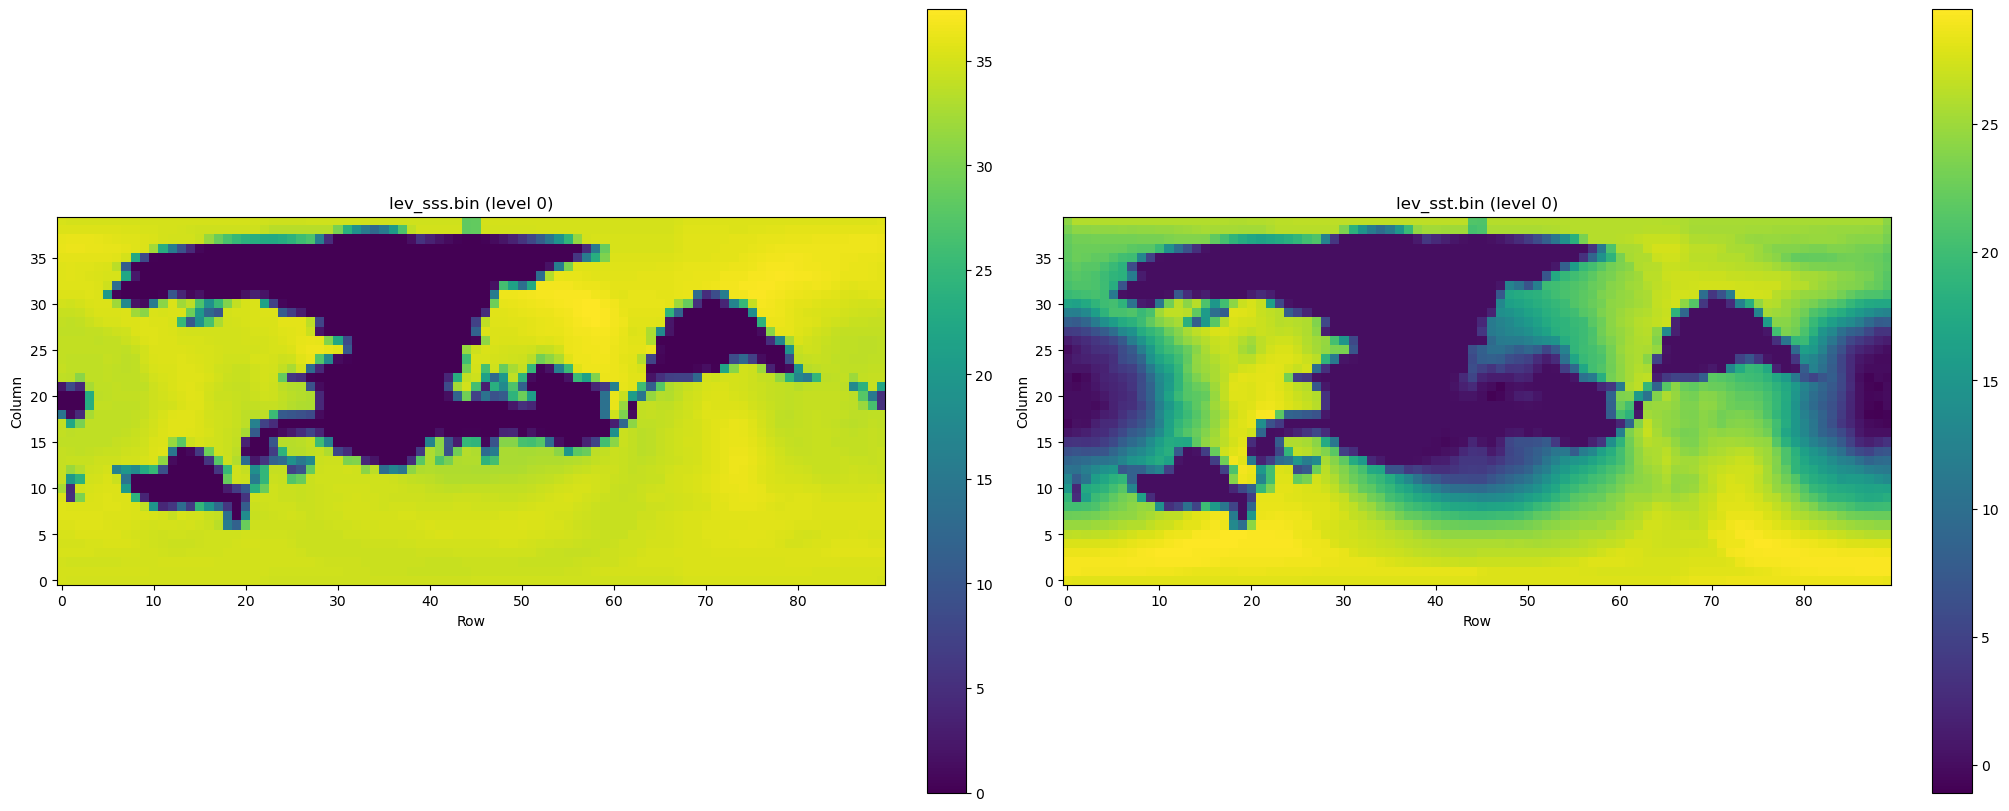

In [ ]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator


GEBCO = r"C:/Users/romed/Desktop/github fixer/cs185c_spring2025/Rotate_The_Earth/GEBCO_2024_sub_ice_topo.nc"
ds4 = xr.open_dataset(GEBCO, chunks={"lat": 4000, "lon": 4000})
F_LON, F_LAT = 60, 60

ds_coarse = (ds4
    .coarsen(lon=F_LON, lat=F_LAT, boundary="trim")
    .mean()
    .compute())

# original coarse mesh
lon_c  = ds_coarse["lon"].values
lat_c  = ds_coarse["lat"].values
bathy_c = ds_coarse["elevation"].values
bathy_c = np.where(bathy_c>0, 0, bathy_c)


lon_ce = np.where(lon_c<0, lon_c+360, lon_c)
idx    = np.argsort(lon_ce)
lon_ce = lon_ce[idx]
bathy_c = bathy_c[:,idx]

lat_orig   = lat_c
lon_orig_e = lon_ce


LAT, LON  = np.meshgrid(lat_orig, lon_orig_e, indexing="ij")
lat_r     = np.deg2rad(LAT)
lon_r     = np.deg2rad(LON)
x         = np.cos(lat_r)*np.cos(lon_r)
y         = np.cos(lat_r)*np.sin(lon_r)
z         = np.sin(lat_r)
xp, yp, zp = z, y, -x

lat_src   = np.rad2deg(np.arcsin(zp))
lon_src   = (np.rad2deg(np.arctan2(yp, xp)) + 360) % 360


new_nlat, new_nlon = 40, 90
lat_factor = bathy_c.shape[0] // new_nlat
lon_factor = bathy_c.shape[1] // new_nlon


base_dir  = r"C:/Users/romed/Desktop/github fixer/cs185c_spring2025/modeldubugging"
files     = ["lev_sss.bin", "lev_sst.bin"]
orig_dims = (90, 40, 12)   

fig, axes = plt.subplots(1, len(files),
                         figsize=(10*len(files), 8),
                         constrained_layout=True)

for ax, fname in zip(axes, files):

    flat  = np.fromfile(os.path.join(base_dir, fname), dtype=">f4")
    arr3d = flat.reshape(orig_dims, order="F").transpose(2,1,0)


    arr3d_rot = np.zeros_like(arr3d)


    for t in range(arr3d.shape[0]):
        lvl_coarse = arr3d[t]
        lvl_fine   = np.repeat(np.repeat(lvl_coarse,
                                         lat_factor, axis=0),
                               lon_factor, axis=1)


        interp = RegularGridInterpolator(
            (lat_orig, lon_orig_e),
            lvl_fine,
            bounds_error=False,
            fill_value=np.nan
        )
        lvl_rot_fine = interp(np.dstack((lat_src, lon_src)))

        for j in range(lvl_rot_fine.shape[1]):
            col   = lvl_rot_fine[:, j]
            valid = ~np.isnan(col)
            if valid.any():
                f = np.argmax(valid)
                l = len(col) - np.argmax(valid[::-1]) - 1
                col[:f]  = col[f]
                col[l+1:]= col[l]
            lvl_rot_fine[:, j] = col
        for i in range(lvl_rot_fine.shape[0]):
            row   = lvl_rot_fine[i, :]
            valid = ~np.isnan(row)
            if valid.any():
                f = np.argmax(valid)
                l = len(row) - np.argmax(valid[::-1]) - 1
                row[:f]  = row[f]
                row[l+1:]= row[l]
            lvl_rot_fine[i, :] = row


        arr3d_rot[t] = lvl_rot_fine.reshape(new_nlat, lat_factor,
                                            new_nlon, lon_factor) \
                                     .mean(axis=(1,3))


    out_flat = arr3d_rot.transpose(2,1,0).reshape(-1, order="F")
    out_fname = os.path.join(base_dir, f"rotated_{fname}")
    out_flat.astype(">f4").tofile(out_fname)
    print(f"Wrote rotated IC to: {out_fname}")

    im = ax.imshow(arr3d_rot[0], origin="lower")
    ax.set_title(fname + " (level 0)")
    ax.set_xlabel("Row")
    ax.set_ylabel("Column")
    fig.colorbar(im, ax=ax, orientation="vertical")

plt.show()


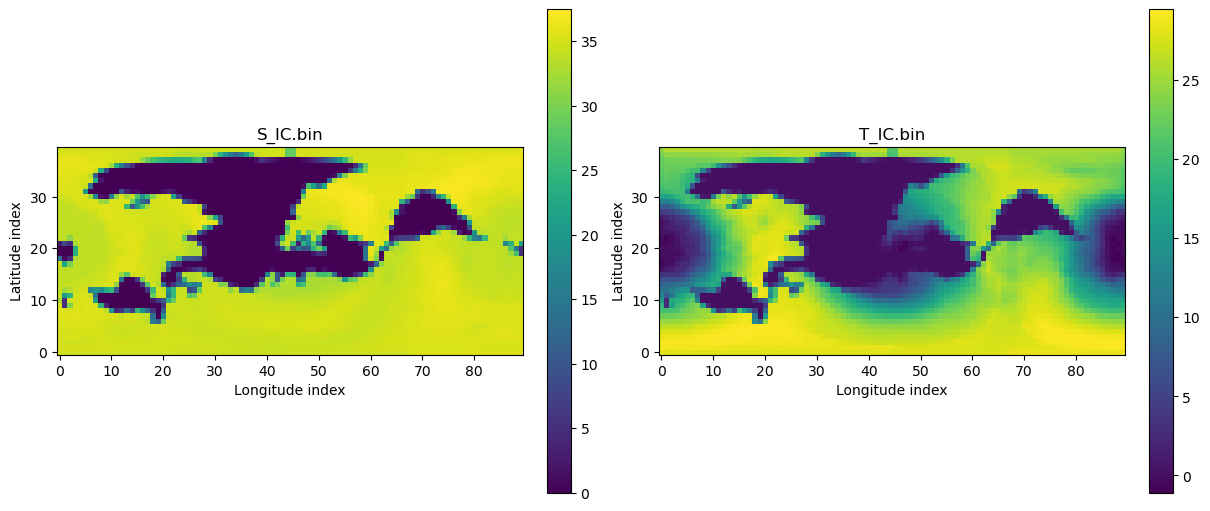

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
base_dir = r"C:/Users/romed/Desktop/github fixer/cs185c_spring2025/modeldubugging"
files = ["S_IC.bin", "T_IC.bin"]
nlat, nlon = 40, 90

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

for ax, fname in zip(axes, files):
    path = os.path.join(base_dir, fname)
    data = np.fromfile(path, dtype=np.float32).reshape((nlat, nlon))
    im = ax.imshow(data, origin='lower')
    ax.set_title(fname)
    ax.set_xlabel("Longitude index")
    ax.set_ylabel("Latitude index")
    fig.colorbar(im, ax=ax, orientation='vertical')

plt.show()
